In [1]:
#!git clone https://github.com/tensorflow/examples.git
!pip install tensorflow tensorflow_datasets matplotlib

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from IPython.display import clear_output

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout
from tensorflow.keras.models import Model

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:4.*.*', with_info=True)

In [4]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [5]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [6]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [7]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

In [8]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
test_batches = test_images.batch(BATCH_SIZE)

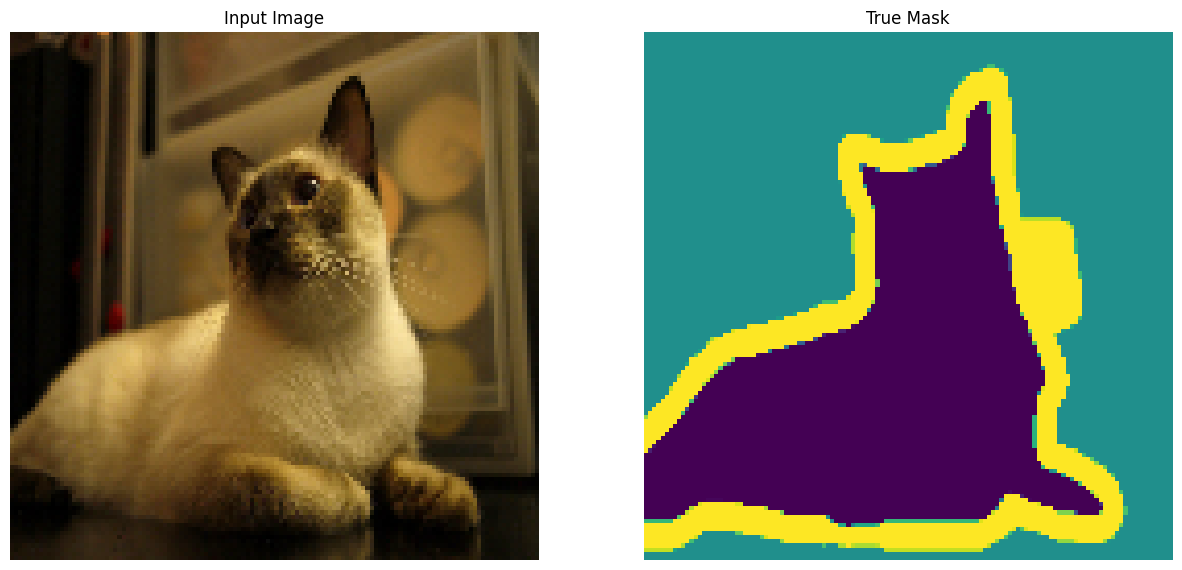

In [9]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

for images, masks in train_batches.take(1):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

In [10]:
def unet_model(output_channels):
    inputs = Input(shape=(128, 128, 3))
    # Encoder
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(256, (3,3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3,3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(512, (3,3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3,3), activation='relu', padding='same')(c4)
    d4 = Dropout(0.5)(c4)
    p4 = MaxPooling2D((2,2))(d4)

    # Bottleneck
    c5 = Conv2D(1024, (3,3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3,3), activation='relu', padding='same')(c5)
    d5 = Dropout(0.5)(c5)

    # Decoder
    u6 = UpSampling2D((2,2), interpolation='bilinear')(d5)
    u6 = Concatenate()([u6, d4])
    c6 = Conv2D(512, (3,3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3,3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2,2), interpolation='bilinear')(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(256, (3,3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3,3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2,2), interpolation='bilinear')(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(128, (3,3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3,3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2,2), interpolation='bilinear')(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(64, (3,3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3,3), activation='relu', padding='same')(c9)

    outputs = Conv2D(output_channels, (1,1), activation=None, padding='same')(c9)
    return Model(inputs=[inputs], outputs=[outputs])

In [11]:
OUTPUT_CLASSES = 3
model = unet_model(OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [12]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


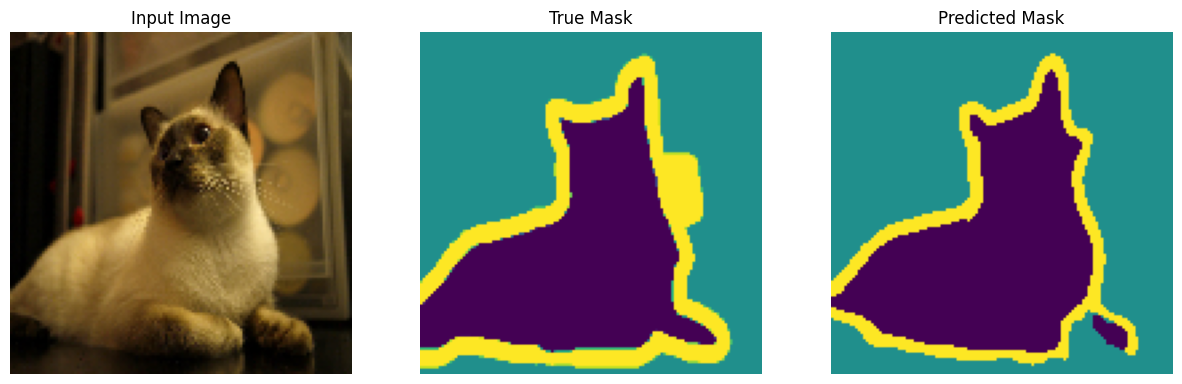


Sample Prediction after epoch 20

57/57 ━━━━━━━━━━━━━━━━━━━━ 634s 11s/step - accuracy: 0.8825 - loss: 0.2827 - val_accuracy: 0.8764 - val_loss: 0.3048


In [13]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(
    train_batches,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_batches,
    callbacks=[DisplayCallback()]
)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


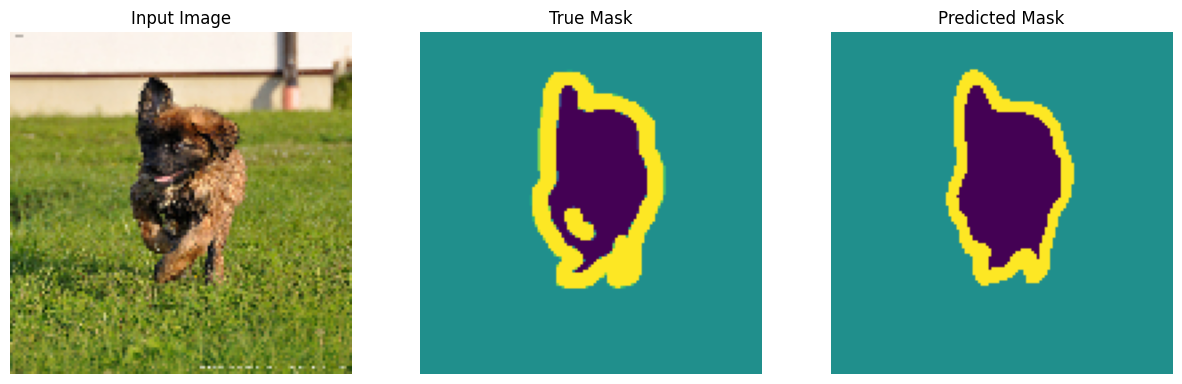

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


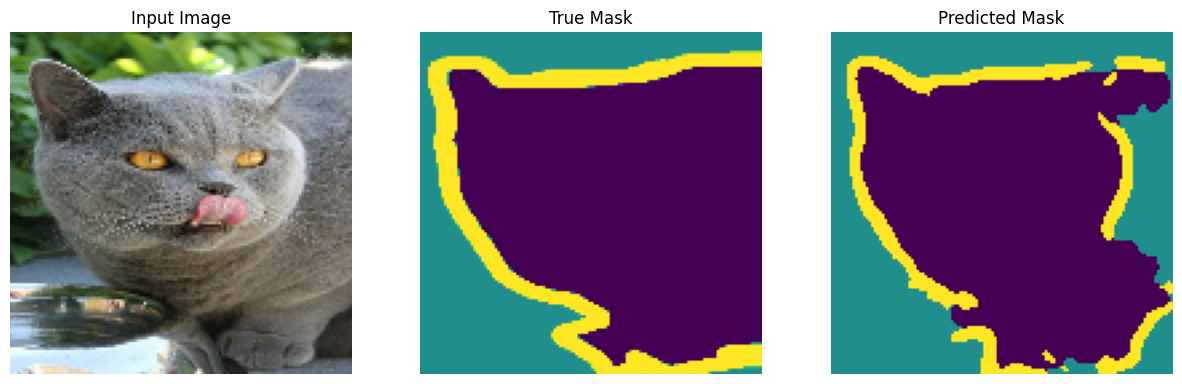

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


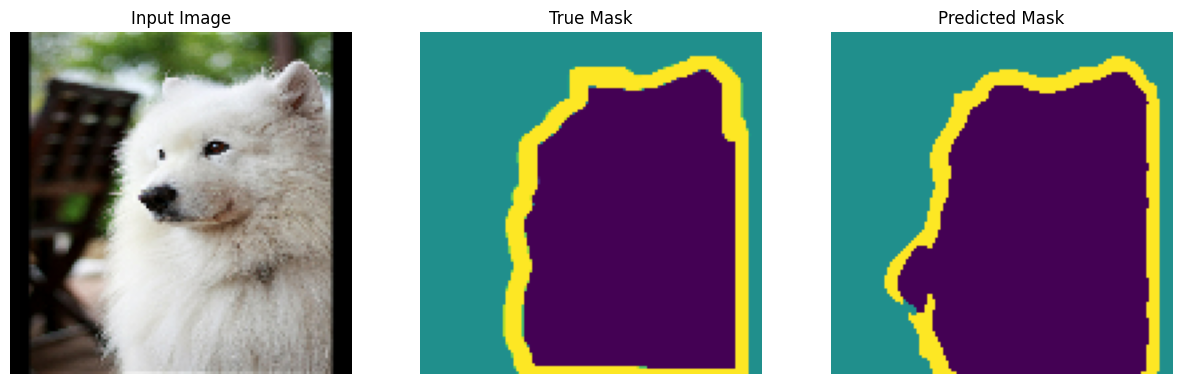

In [14]:
show_predictions(test_batches, 3)